Library necessary imports:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn as nn
import pandas as pd
import torchvision
from PIL import Image
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

%matplotlib inline
sns.set(style="whitegrid")

In [3]:
base_dir = 'ASL/asl_alphabet_train/asl_alphabet_train'
X_list = []
y_list = []

for label_name in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label_name)
    if not os.path.isdir(label_dir):
        continue
    
    for fname in os.listdir(label_dir):
        fpath = os.path.join(label_dir, fname)
        img = Image.open(fpath).convert('L')  
        img = img.resize((28, 28))           
        arr = np.array(img).astype('float32') / 255.0
        X_list.append(arr.flatten())        
        y_list.append(label_name)       

X = np.array(X_list)
y = np.array(y_list)

Preprocessing for classic models:

In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Separate data into train set and test set:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y       
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (69600, 784) Test: (17400, 784)


In [6]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Function to evaluate models:

In [11]:
def eval_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')
    
    print(f" {name}")
    print("Accuracy:", acc)
    print("F1 score (weighted):", f1)
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap='Purples')
    plt.xlabel("Predict")
    plt.ylabel("Real")
    plt.title(f"Confusion Matrix – {name}")
    plt.show()
    
    return model, y_pred, acc, f1

Classification models:

### Neural Network MLP

In [79]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [15]:
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

mlp_model = MLP(X_train_std.shape[1], len(le.classes_))


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 1127.7514
Epoch 2, Loss: 373.4659
Epoch 3, Loss: 249.0966
Epoch 4, Loss: 206.1787
Epoch 5, Loss: 164.2864
Epoch 6, Loss: 154.8046
Epoch 7, Loss: 143.7789
Epoch 8, Loss: 126.2417
Epoch 9, Loss: 124.1588
Epoch 10, Loss: 124.3544


In [18]:
mlp_model.eval()
preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        outputs = mlp_model(xb)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())

mlp_acc = accuracy_score(y_test, preds)
mlp_f1  = f1_score(y_test, preds, average='weighted')

print("MLP Accuracy:", mlp_acc)
print("MLP F1:", mlp_f1)


MLP Accuracy: 0.9420689655172414
MLP F1: 0.9420617264869597


### Convolutional Neural Network CNN

In [78]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),    
    transforms.RandomRotation(degrees=15)      
])

In [80]:
class ASLDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.images[idx]    
        y = self.labels[idx]

        if self.transform is not None:
            x = self.transform(x) 

        return x, y

In [81]:
X_train_img = X_train.reshape(-1, 1, img_size, img_size)
X_test_img  = X_test.reshape(-1, 1, img_size, img_size)

X_train_img_t = torch.tensor(X_train_img, dtype=torch.float32)
X_test_img_t  = torch.tensor(X_test_img, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_cnn_ds = ASLDataset(X_train_img_t, y_train_t, transform=train_transform)
test_cnn_ds  = ASLDataset(X_test_img_t, y_test_t, transform=None)

train_cnn_loader = DataLoader(train_cnn_ds, batch_size=32, shuffle=True)
test_cnn_loader  = DataLoader(test_cnn_ds, batch_size=32, shuffle=False)

In [82]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = CNN(len(le.classes_))

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    cnn_model.train()
    
    for xb, yb in train_cnn_loader:
        optimizer.zero_grad()
        outputs = cnn_model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1} completed")

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed


In [84]:
cnn_model.eval()
cnn_preds = []

with torch.no_grad():
    for xb, _ in test_cnn_loader:
        outputs = cnn_model(xb)
        _, predicted = torch.max(outputs, 1)
        cnn_preds.extend(predicted.numpy())

cnn_acc = accuracy_score(y_test, cnn_preds)
cnn_f1  = f1_score(y_test, cnn_preds, average='weighted')

print("CNN Accuracy:", cnn_acc)
print("CNN F1:", cnn_f1)

CNN Accuracy: 0.8397126436781609
CNN F1: 0.8400347340139306


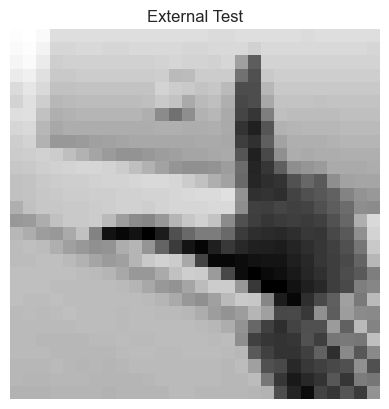

In [136]:
imagen = "Image23.png"  

img = Image.open(imagen).convert("L")
img = img.resize((img_size, img_size))
img_array = np.array(img) / 255.0

img_tensor = torch.tensor(img_array).unsqueeze(0).unsqueeze(0).float()

plt.imshow(img_array, cmap="gray")
plt.title("External Test") 
plt.axis("off")
plt.show()

In [138]:
classes=le.classes_
cnn_model.eval()
with torch.no_grad():
    output = cnn_model(img_tensor)
    pred = torch.argmax(output, dim=1).item()

print("Model Prediction:", classes[pred])

Model Prediction: H


In [77]:
1, 4, 16

'Image20.png'